# Demonstration: Algorithmic Recourse with Multiple Imputation (ARMIN)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

## 1. Dataset and Classifier

In [2]:
from datasets import Dataset

D = Dataset()
X_tr, X_ts, y_tr, y_ts = D.get_dataset(split=True)

D.get_details()

,Feature,Type,Min,Max,Immutable,Constraint
0,RevolvingUtilizationOfUnsecuredLines,Real,0.0,1.246275e+01,No,Nothing
1,age,Integer,0.0,1.030000e+02,Yes,Fix
2,NumberOfTime30-59DaysPastDueNotWorse,Integer,0.0,1.300000e+01,No,Nothing
3,DebtRatio,Real,0.0,3.488000e+03,No,Nothing
4,MonthlyIncome,Integer,0.0,3.008750e+06,No,Nothing
5,NumberOfOpenCreditLinesAndLoans,Integer,0.0,5.800000e+01,No,Nothing
6,NumberOfTimes90DaysLate,Integer,0.0,1.700000e+01,No,Nothing
7,NumberRealEstateLoansOrLines,Integer,0.0,5.400000e+01,No,Nothing
8,NumberOfTime60-89DaysPastDueNotWorse,Integer,0.0,1.100000e+01,No,Nothing
9,NumberOfDependents,Integer,0.0,2.000000e+01,Yes,Fix


In [3]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
clf = clf.fit(X_tr, y_tr)

print('Accuracy: {:.2%}'.format(clf.score(X_ts, y_ts)))
pd.DataFrame([[f, w] for f, w in zip(D.feature_names, clf.coef_[0])], columns=['Feature', 'Coefficient'])

Accuracy: 93.40%


,Feature,Coefficient
0,RevolvingUtilizationOfUnsecuredLines,1.343918
1,age,-0.028888
2,NumberOfTime30-59DaysPastDueNotWorse,0.443853
3,DebtRatio,-0.000522
4,MonthlyIncome,-0.000041
5,NumberOfOpenCreditLinesAndLoans,0.016817
6,NumberOfTimes90DaysLate,0.720687
7,NumberRealEstateLoansOrLines,0.131350
8,NumberOfTime60-89DaysPastDueNotWorse,0.593074
9,NumberOfDependents,-0.003086


## 2. Recourse Action before Missing

In [4]:
X_old = X_ts[X_ts[:, 1] > np.median(X_tr[:, 1])]
X_target = X_old[clf.predict(X_old)==1]

n = 10
pd.DataFrame([X_target[n], clf.coef_[0]], columns=D.feature_names, index=['Before Missing', 'Coefficient']).T

,Before Missing,Coefficient
RevolvingUtilizationOfUnsecuredLines,0.342003,1.343918
age,70.000000,-0.028888
NumberOfTime30-59DaysPastDueNotWorse,1.000000,0.443853
DebtRatio,0.489300,-0.000522
MonthlyIncome,2756.000000,-0.000041
NumberOfOpenCreditLinesAndLoans,6.000000,0.016817
NumberOfTimes90DaysLate,5.000000,0.720687
NumberRealEstateLoansOrLines,0.000000,0.131350
NumberOfTime60-89DaysPastDueNotWorse,0.000000,0.593074
NumberOfDependents,0.000000,-0.003086


In [5]:
from armin import AlgorithmicRecourseExplainer

ar = AlgorithmicRecourseExplainer(clf, X_tr, y_tr, **D.params, quantile=(0.01, 0.99))
action = ar.extract(X_target[n])
print(ar.getActionObject(action))

* Action (SeriousDlqin2yrs: Yes -> No):
	* RevolvingUtilizationOfUnsecuredLines: 0.3420 -> 0.1942 (-0.1478)
* Scores: 
	* feasible: True
	* valid: True
	* cost: 0.39621847
	* probability: {'No': 0.5008386061943159, 'Yes': 0.49916139380568414}
	* time: 0.02503800



## 3. Recourse Action after Missing

In [6]:
from armin.missing_helper import MissingGenerator

mg = MissingGenerator(feature_types=D.feature_types, feature_categories=D.feature_categories)
X_missing = mg.mask_instances(X_target, n_missing=1, m_=[4])

pd.DataFrame([X_target[n], X_missing[n], clf.coef_[0]], columns=D.feature_names, index=['Before Missing', 'After Missing', 'Coefficient']).T

,Before Missing,After Missing,Coefficient
RevolvingUtilizationOfUnsecuredLines,0.342003,0.342003,1.343918
age,70.000000,70.000000,-0.028888
NumberOfTime30-59DaysPastDueNotWorse,1.000000,1.000000,0.443853
DebtRatio,0.489300,0.489300,-0.000522
MonthlyIncome,2756.000000,NaN,-0.000041
NumberOfOpenCreditLinesAndLoans,6.000000,6.000000,0.016817
NumberOfTimes90DaysLate,5.000000,5.000000,0.720687
NumberRealEstateLoansOrLines,0.000000,0.000000,0.131350
NumberOfTime60-89DaysPastDueNotWorse,0.000000,0.000000,0.593074
NumberOfDependents,0.000000,0.000000,-0.003086


### [Baseline 1] Algorithmic Recourse with Single Imputation

In [7]:
from armin.missing_helper import SingleImputer

si = SingleImputer(imputer_type='mean', feature_types=D.feature_types, feature_categories=D.feature_categories)
si = si.fit(X_tr)

In [8]:
from armin.baselines import ImputationAlgorithmicRecourseExplainer

iar = ImputationAlgorithmicRecourseExplainer(clf, si, X_tr, y_tr, **D.params, quantile=(0.01, 0.99))
action = iar.extract(X_missing[n])
action = iar.updateActionDicts(X_target[n], action)
print(iar.getActionObject(action))

* Action (SeriousDlqin2yrs: Yes -> Yes):
	* RevolvingUtilizationOfUnsecuredLines: 0.3420 -> 0.3129 (-0.0291)
* Scores: 
	* feasible: True
	* valid: False
	* cost: 0.07504983
	* probability: {'No': 0.46103554029117555, 'Yes': 0.5389644597088245}
	* time: 0.00730801



### [Baseline 2] Robust Algorithmic Recourse

In [9]:
from armin.missing_helper import MultipleImputer

mi = MultipleImputer(n_sampling=100, imputer_type='mice', feature_types=D.feature_types, feature_categories=D.feature_categories)
mi = mi.fit(X_tr)

In [10]:
from armin.baselines import RobustAlgorithmicRecourseExplainer

rar = RobustAlgorithmicRecourseExplainer(clf, mi, X_tr, y_tr, **D.params, quantile=(0.01, 0.99))
action = rar.extract(X_missing[n])
action = rar.updateActionDicts(X_target[n], action)
print(rar.getActionObject(action))

* Action (SeriousDlqin2yrs: Yes -> No):
	* NumberOfTimes90DaysLate: 5 -> 2 (-3)
* Scores: 
	* feasible: True
	* valid: True
	* cost: 3.00939191
	* probability: {'No': 0.8772709375477947, 'Yes': 0.12272906245220527}
	* time: 0.53247452



### [Our Proposal] Algorithmic Recourse with Multiple Imputation (ARMIN)

In [11]:
from armin import ArminExplainer

armin = ArminExplainer(clf, mi, X_tr, y_tr, **D.params, quantile=(0.01, 0.99))
action = armin.extract(X_missing[n])
action = armin.updateActionDicts(X_target[n], action)
print(armin.getActionObject(action))

* Action (SeriousDlqin2yrs: Yes -> No):
	* RevolvingUtilizationOfUnsecuredLines: 0.3420 -> 0.1727 (-0.1693)
* Scores: 
	* feasible: True
	* valid: True
	* cost: 0.46061047
	* probability: {'No': 0.5080892158929953, 'Yes': 0.4919107841070048}
	* time: 0.02667999



## 4. Confidence Path (Optional)

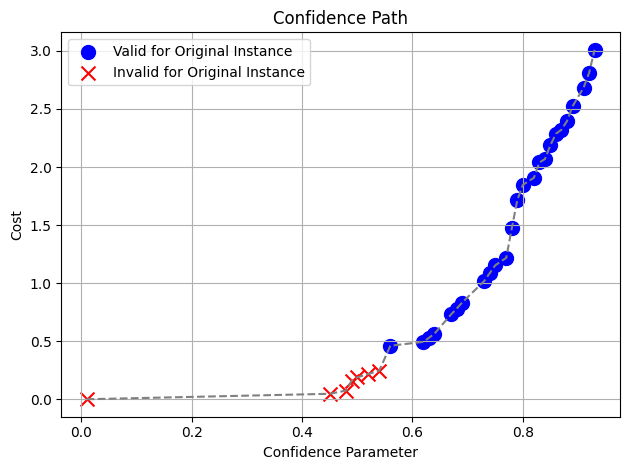

In [12]:
path = armin.confidence_path(X_missing[n])

rhos = []
costs = []
valids = []
for (rho, action) in path:
    action = armin.updateActionDicts(X_target[n], action)
    rhos.append(rho)
    costs.append(action['cost'])
    valids.append(action['valid'])
rhos = np.array(rhos)
costs = np.array(costs)
valids = np.array(valids)

plt.plot(rhos, costs, c='gray', linestyle='dashed')
plt.scatter(rhos[valids], costs[valids], c='blue', label='Valid for Original Instance', s=100, marker='o')
plt.scatter(rhos[~valids], costs[~valids], c='red', label='Invalid for Original Instance', s=100, marker='x')
plt.title('Confidence Path')
plt.xlabel('Confidence Parameter')
plt.ylabel('Cost')
plt.legend()
plt.grid()
plt.tight_layout()